In [1]:
import numpy as np
import scipy.stats.distributions as ds
import matplotlib.pyplot as plt

from mud.base import DensityProblem

import mud_examples.poisson as ps

In [2]:
sample_dist = "u"
input_dim = 2
prefix = 1000
fdir = f"pde_{input_dim}D"
fname = f"data/{fdir}/ref_{prefix}_{input_dim}{sample_dist}.pkl"

P = ps.pdeProblem(fname)
P.load()
if sample_dist == "n":
    P.dist = ds.norm  # required for generator functions
    loc = -2.0
    scale = 0.2
else:
    P.dist = ds.uniform
    loc = -4.0
    scale = 4.0

In [3]:
print(fname)

data/pde_2D/ref_1000_2u.pkl


In [4]:
num_samples, num_max_qoi = P.qoi.shape
print(f"There are {num_max_qoi} sensors available and {num_samples} samples of {input_dim}-D parameter space.")

There are 500 sensors available and 1000 samples of 2-D parameter space.


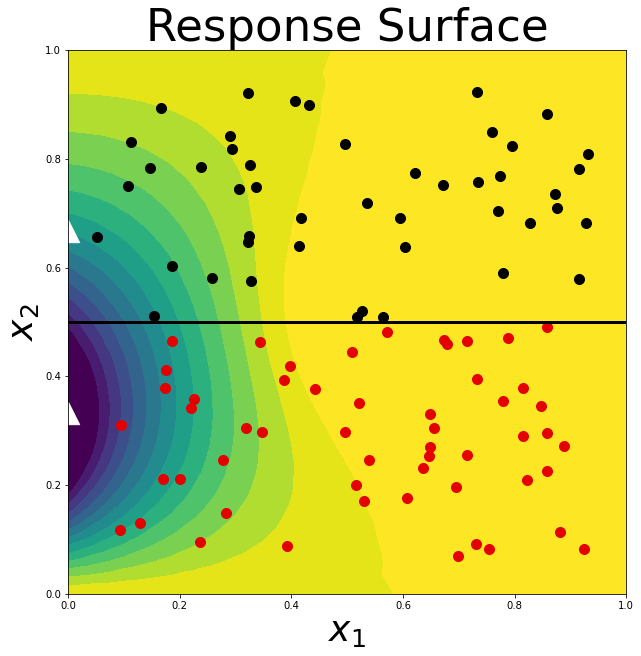

In [5]:
# modify this method for new plot based on singular vectors
num_qoi = 2
ps.plot_without_fenics(
    fname,
    num_sensors=100,
    mode="hor",
    num_qoi=num_qoi,
    example="mud",  # TODO: rename this variable
)

# Baseline Solution

In [6]:
# generator function which takes (num_obs, sd) as arguments and returns a mud_problem
mud_generator = P.mud_vector_horizontal(num_qoi, loc=loc, scale=scale)

In [7]:
mud_problem = mud_generator(500, 0.01) # simulates noisy measurements

In [8]:
mud_problem

In [9]:
mud_problem.mud_point()

array([-3.51107586, -0.17405855])

# Reference Solution

In [10]:
# TODO : turn this snippet into a method
closest_fit_index_out = np.argmin(
    np.linalg.norm(P.qoi - np.array(P.qoi_ref), axis=1)
)
g_projected = P.lam[closest_fit_index_out, :].ravel()
lam_true = g_projected
print(lam_true)

[-3.19450497 -0.44650169]


# SVD Approach

In [11]:
num_obs = 500
sd = 0.05
measure_true = P.qoi_ref[0:num_obs]
measurements = P.qoi[:, 0:num_obs]
noise = np.random.randn(num_obs) * sd
data = measure_true + noise
# q = wme(qoi, data, sd).reshape(-1, 1)

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
scalar = StandardScaler()

In [14]:
residuals = (measurements - data) / sd
X = scalar.fit_transform(residuals)

In [15]:
U, singular_values, singular_vectors = np.linalg.svd(X)

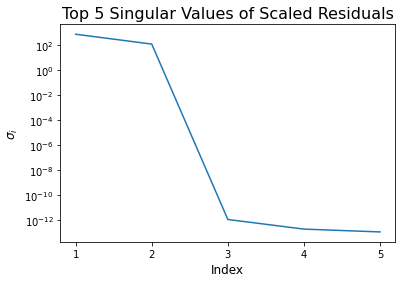

In [16]:
top_singular_values = 5
inds = np.arange(1, top_singular_values+1)
plt.plot(inds, singular_values[0:top_singular_values])
plt.xticks(inds)
plt.xlabel("Index", fontsize=12)
plt.ylabel("$\sigma_i$", fontsize=12)
plt.yscale('log')
plt.title(f"Top {top_singular_values} Singular Values of Scaled Residuals", fontsize=16)
plt.show()

In [17]:
scalar = StandardScaler()
S = scalar.fit_transform(singular_vectors)

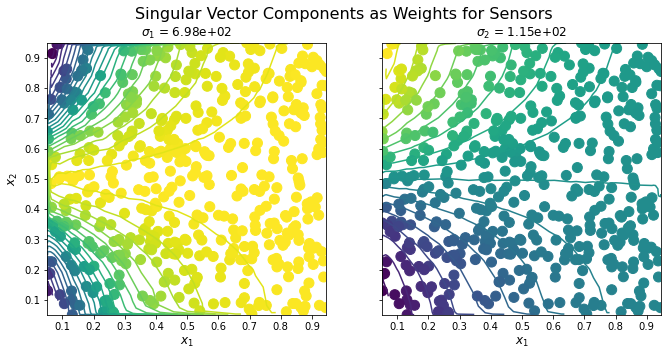

In [18]:
top_singular_vectors = 2
fig, ax = plt.subplots(1, top_singular_vectors, figsize=(1+5*top_singular_vectors, 5), sharey=True)
for i in range(top_singular_vectors):
    ax[i].tricontour(P.sensors[0:num_obs, 0], P.sensors[0:num_obs, 1], singular_vectors[i, :], levels=20, alpha=1)
    ax[i].scatter(P.sensors[0:num_obs, 0], P.sensors[0:num_obs, 1], s=100, c=singular_vectors[i, :])
    ax[i].set_title(f"$\sigma_{i+1}$ = {singular_values[i]:1.2e}")
    ax[i].set_xlabel("$x_1$", fontsize=12)
    if i == 0: ax[i].set_ylabel("$x_2$", fontsize=12)
fig.suptitle("Singular Vector Components as Weights for Sensors", fontsize=16)
fig.show()

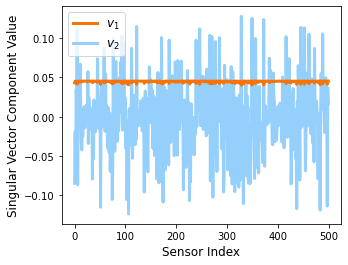

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))
# plt.plot((singular_vectors[0, :] + singular_vectors[1, :]))
ax.plot(singular_vectors[0, :], c='xkcd:orange', label="$v_1$", lw=3)
ax.plot(singular_vectors[1, :], c='xkcd:light blue', label="$v_2$", lw=3, zorder=0)
ax.legend(fontsize=12)
ax.set_xlabel("Sensor Index", fontsize=12)
ax.set_ylabel("Singular Vector Component Value", fontsize=12)
fig.show()

In [20]:
# fig, ax = plt.subplots(figsize=(3,3))
# ax.scatter(P.sensors[0:num_obs, 0], P.sensors[0:num_obs, 1], s=100, c= (singular_vectors[0, :] + singular_vectors[1, :]))
# fig.show()

In [21]:
num_qoi = 2
new_qoi_map = singular_vectors[0:num_qoi, :]
new_qoi = residuals @ new_qoi_map.T  # ok shape, wrong solution, identical to using U@sigma

In [22]:
ax.contour

<bound method Axes.contour of <AxesSubplot:xlabel='Sensor Index', ylabel='Singular Vector Component Value'>>

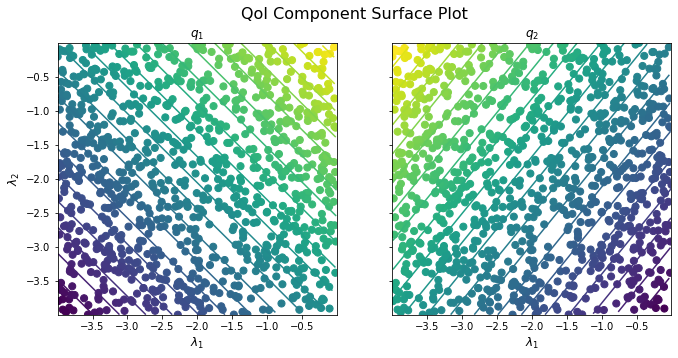

In [23]:
top_singular_vectors = 2
fig, ax = plt.subplots(1, top_singular_vectors, figsize=(1+5*top_singular_vectors, 5), sharey=True)
for i in range(top_singular_vectors):
    ax[i].scatter(P.lam[:,0], P.lam[:,1], s=50, c=new_qoi[:,i])
    ax[i].tricontour(P.lam[:,0], P.lam[:,1], new_qoi[:,i], levels=20)
#     ax[i].set_title(f"$\sigma_{i}$ = {singular_values[i]:1.2e}")
    ax[i].set_title(f"$q_{i+1}$", fontsize=12)
    ax[i].set_xlabel("$\lambda_1$", fontsize=12)
    if i == 0: ax[i].set_ylabel("$\lambda_2$", fontsize=12)
# fig.supylabel("$\lambda_2$")
fig.suptitle("QoI Component Surface Plot", fontsize=16)
fig.show()

In [24]:
d = DensityProblem(P.lam, new_qoi, P.domain, weights=None)
print(d.mud_point())

[-3.59359639 -0.03705355]


In [ ]:
P.plot()
plt.plot(np.linspace(0, 1, input_dim + 2), [0] + list(d.mud_point()) + [0], lw=5, c='blue', label='svd')
plt.plot(np.linspace(0, 1, input_dim + 2), [0] + list(mud_problem.mud_point()) + [0], lw=5, c='purple', label='split')
plt.legend()
plt.show()